<a href="https://colab.research.google.com/github/VivaanthecoderGOAT/projects/blob/main/crash_analytics_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
from sklearn.cluster import KMeans

# Exploratory Data Analysis (EDA)

In [ ]:
#Load Dataset
file_path = "Final Tx dataset.csv"
df = pd.read_csv(file_path)

#print Dataset Info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9816 entries, 0 to 9815
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Crash ID                               9816 non-null   int64 
 1   Adjusted Average Daily Traffic Amount  9816 non-null   object
 2   City                                   9816 non-null   object
 3   Crash Month                            9816 non-null   int64 
 4   Crash Severity                         9816 non-null   object
 5   Crash Time                             9816 non-null   int64 
 6   Crash Year                             9816 non-null   int64 
 7   Day of Week                            9816 non-null   object
 8   Intersecting Street Name               9816 non-null   object
 9   Manner of Collision                    9816 non-null   object
 10  Speed Limit                            9816 non-null   int64 
 11  Street Name      

In [ ]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Check the total number of missing values
total_missing = df.isnull().sum().sum()
print("\nTotal missing values in dataset:", total_missing)

# Convert "no data" values to NaN
df["Adjusted Average Daily Traffic Amount"] = df["Adjusted Average Daily Traffic Amount"].replace("No Data", pd.NA)

# Check missing values
missing_traffic = df["Adjusted Average Daily Traffic Amount"].isnull().sum()
total_traffic = len(df)
print(f"Missing values in 'Adjusted Average Daily Traffic Amount': {missing_traffic} out of {total_traffic}")

Missing values in each column:
 Crash ID                                 0
Adjusted Average Daily Traffic Amount    0
City                                     0
Crash Month                              0
Crash Severity                           0
Crash Time                               0
Crash Year                               0
Day of Week                              0
Intersecting Street Name                 0
Manner of Collision                      0
Speed Limit                              0
Street Name                              0
dtype: int64

Total missing values in dataset: 0
Missing values in 'Adjusted Average Daily Traffic Amount': 5996 out of 9816


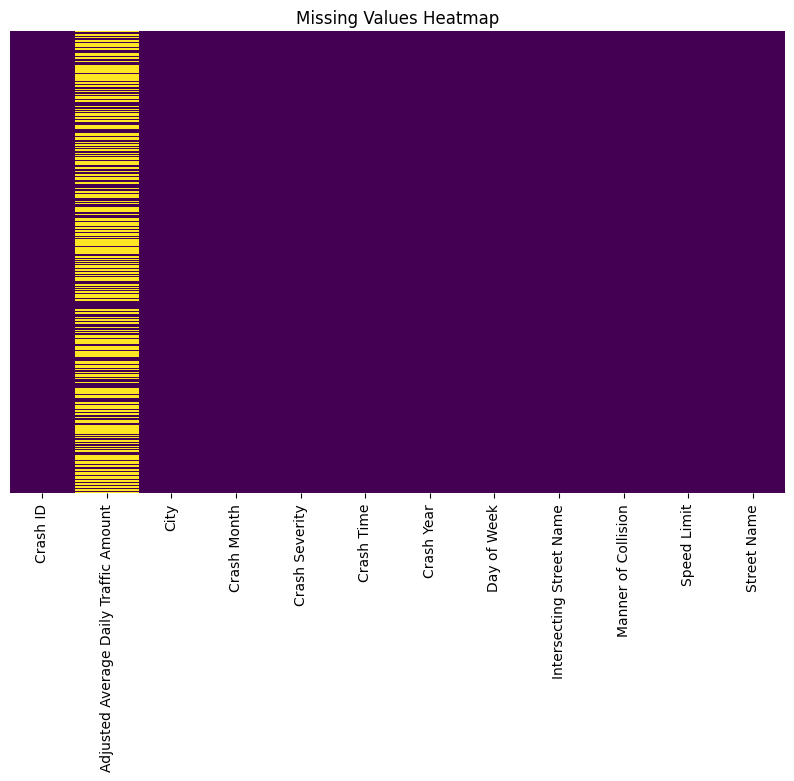

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [ ]:
#drop the highest missing value column
df = df.drop(columns=["Adjusted Average Daily Traffic Amount"])


In [ ]:
#categorize crash times
def categorize_time(crash_time):
    if 500 <= crash_time < 1200:
        return "Morning"
    elif 1200 <= crash_time < 1700:
        return "Afternoon"
    elif 1700 <= crash_time < 2100:
        return "Evening"
    elif 2100 <= crash_time < 2400:
        return "Night"
    else:
        return "Late Night"

df["Crash Time Category"] = df["Crash Time"].apply(categorize_time)

<ipython-input-50-ea9974e3b53c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Crash Time Category",


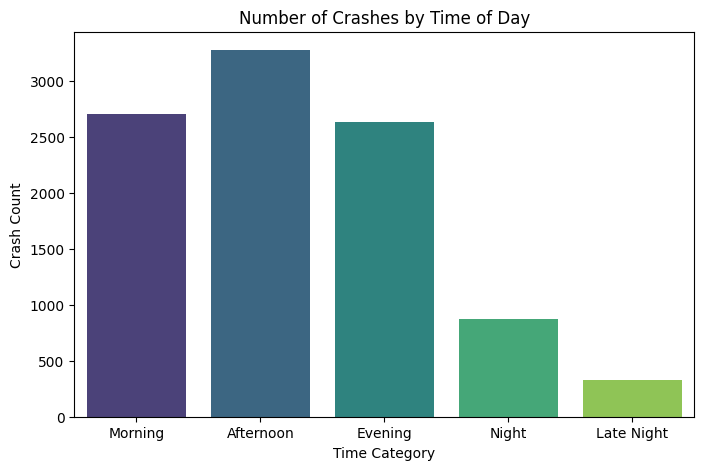

In [ ]:
#Crash time distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Crash Time Category",
              order=["Morning", "Afternoon", "Evening", "Night", "Late Night"],
              palette="viridis")
plt.title("Number of Crashes by Time of Day")
plt.xlabel("Time Category")
plt.ylabel("Crash Count")
plt.show()

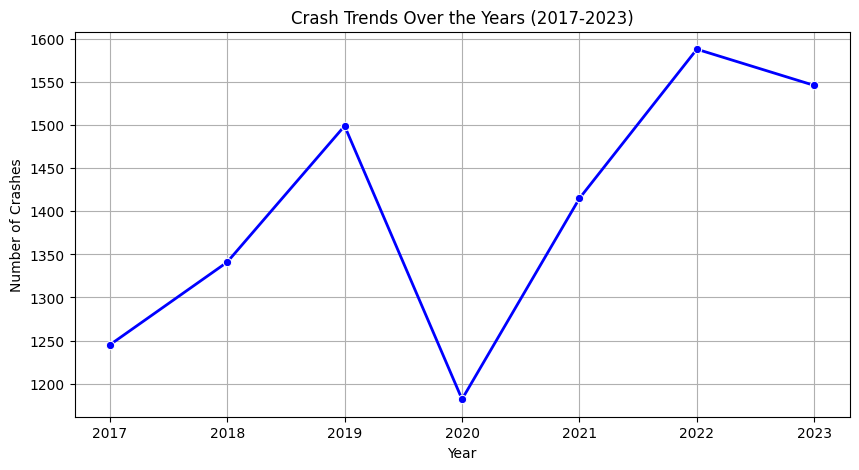

In [ ]:
#Crash Trends over the years
plt.figure(figsize=(10, 5))
crashes_per_year = df["Crash Year"].value_counts().sort_index()
sns.lineplot(x=crashes_per_year.index, y=crashes_per_year.values,
             marker="o", color="b", linewidth=2)
plt.title("Crash Trends Over the Years (2017-2023)")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")
plt.xticks(crashes_per_year.index)
plt.grid(True)
plt.show()

<ipython-input-52-501e9b372cef>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_streets.values, y=top_streets.index, palette="rocket")


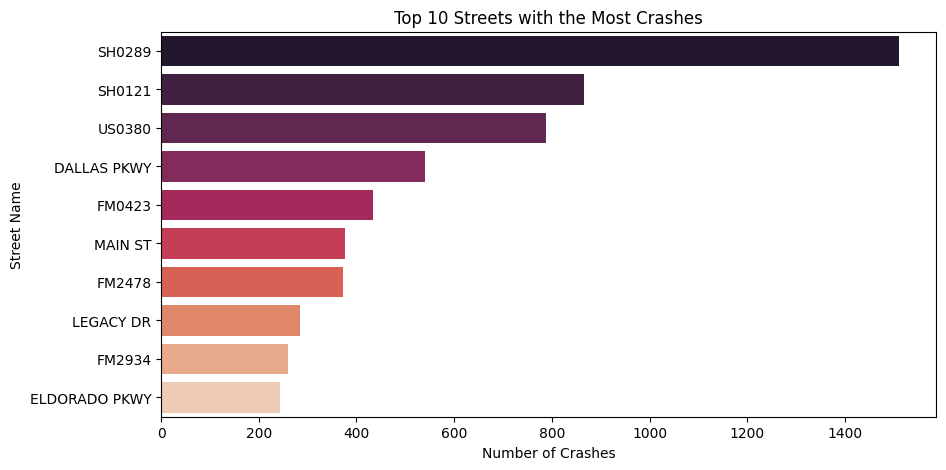

In [ ]:
#High Crash streets
plt.figure(figsize=(10, 5))
top_streets = df["Street Name"].value_counts().head(10)
sns.barplot(x=top_streets.values, y=top_streets.index, palette="rocket")
plt.title("Top 10 Streets with the Most Crashes")
plt.xlabel("Number of Crashes")
plt.ylabel("Street Name")
plt.show()

<ipython-input-53-5bb622f1ec43>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_common_crashes.values, y=most_common_crashes.index, palette="coolwarm")


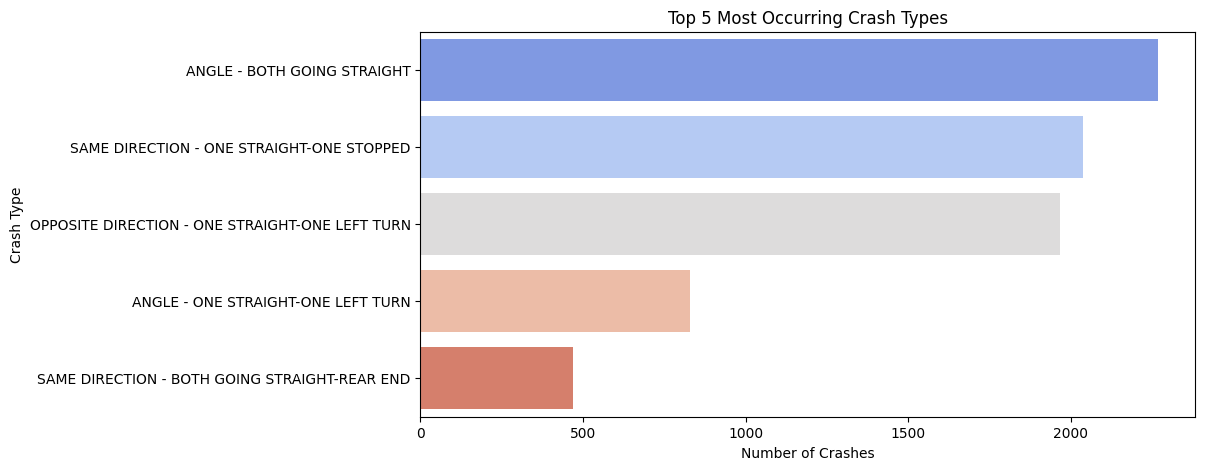

In [ ]:
#most common crash type
plt.figure(figsize=(10, 5))
most_common_crashes = df["Manner of Collision"].value_counts().head(5)
sns.barplot(x=most_common_crashes.values, y=most_common_crashes.index, palette="coolwarm")
plt.title("Top 5 Most Occurring Crash Types")
plt.xlabel("Number of Crashes")
plt.ylabel("Crash Type")
plt.show()

# Finding best features for crash analytics prediction using ML


In [ ]:
#encoding experimentation
label_encoders = {}

# Try different combinations of features to encode
encoded_columns = ["Street Name", "Intersecting Street Name", "City", "Crash Time Category", "Day of Week", "Manner of Collision", "Crash Month", "Speed Limit"]
for col in encoded_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define multiple feature combinations to test
feature_sets = {
    "Location Only": ["Street Name", "Intersecting Street Name", "City"],
    "Time Only": ["Crash Year", "Crash Month","Crash Time Category", "Day of Week"],
    "Location + Time": ["Street Name", "Intersecting Street Name", "City", "Crash Year", "Crash Time Category", "Day of Week", "Crash Month"],
    "Location + Crash Type": ["Street Name", "Intersecting Street Name", "City", "Manner of Collision"],
    "All Features": ["Street Name", "Intersecting Street Name", "City", "Crash Year", "Crash Time Category", "Day of Week", "Manner of Collision", "Crash Month", "Speed Limit"]
}





In [ ]:
#train and eval models
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

best_accuracy = 0
best_feature_set = None
best_model = None
for feature_name, features in feature_sets.items():
    print(f" Training with Feature Set: {feature_name}")

    # Select features and target
    X = df[features]
    y = df["Crash Severity"]

    # Encode Crash Severity labels
    le_severity = LabelEncoder()
    y = le_severity.fit_transform(y)

    #Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train model
    model = GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight="balanced"),
        param_grid, cv=5, scoring='accuracy'
    )
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f" Accuracy: {accuracy:.2f}")

    # Track best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_feature_set = feature_name
        best_model = model.best_estimator_

print(f"\n Best Feature Set: {best_feature_set} with Accuracy: {best_accuracy:.2f}")


 Training with Feature Set: Location Only
 Accuracy: 0.30
 Training with Feature Set: Time Only
 Accuracy: 0.34
 Training with Feature Set: Location + Time
 Accuracy: 0.53
 Training with Feature Set: Location + Crash Type
 Accuracy: 0.39
 Training with Feature Set: All Features
 Accuracy: 0.55

 Best Feature Set: All Features with Accuracy: 0.55


# Clustering crash hotspots with KMeans


 Performing Clustering & Generating Heatmap...


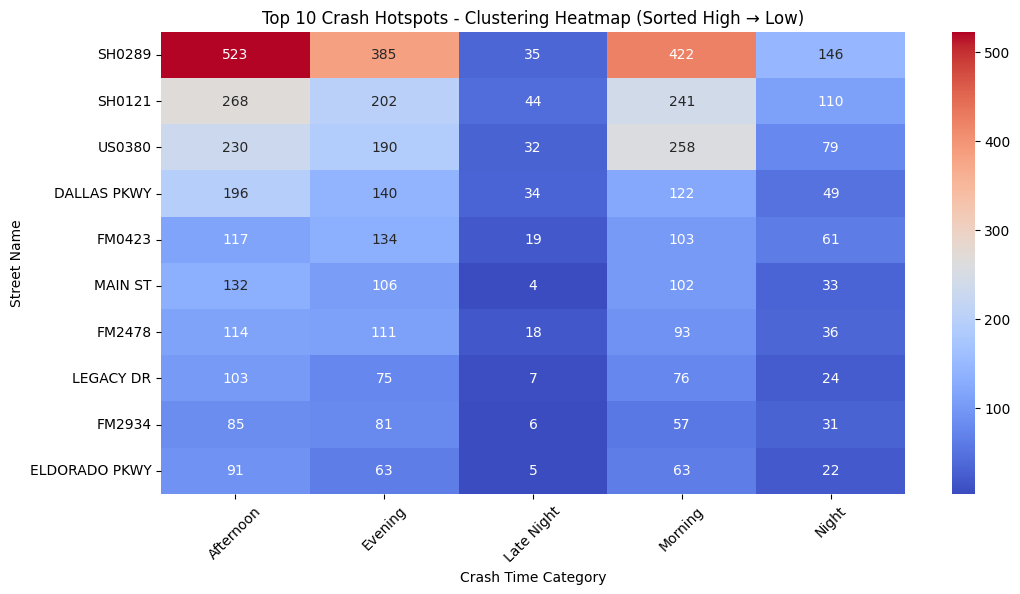

In [ ]:
print("\n Performing Clustering & Generating Heatmap...")

# Use only location-based features for clustering
X_cluster = df[["Street Name", "Intersecting Street Name", "City"]]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_cluster)

# Identify top 10 crash hotspots based on total crash frequency
top_hotspots = df["Street Name"].value_counts().head(10).index
df_top_hotspots = df[df["Street Name"].isin(top_hotspots)].copy()  # Ensure independent copy

# Decode categorical values for readability
df_top_hotspots["Street Name"] = df_top_hotspots["Street Name"].map(lambda x: label_encoders["Street Name"].inverse_transform([x])[0])
df_top_hotspots["Crash Time Category"] = df_top_hotspots["Crash Time Category"].map(lambda x: label_encoders["Crash Time Category"].inverse_transform([x])[0])

# Create heatmap data with total crash counts per street & time category
heatmap_data = df_top_hotspots.pivot_table(index="Street Name", columns="Crash Time Category", values="Cluster", aggfunc="count")

# Sort streets from highest to lowest cluster count
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt="d")
plt.title("Top 10 Crash Hotspots - Clustering Heatmap (Sorted High → Low)")
plt.xlabel("Crash Time Category")
plt.ylabel("Street Name")
plt.xticks(rotation=45)
plt.show()

# Display best model results

 Model Performance Report:
                              precision    recall  f1-score   support

                99 - UNKNOWN       1.00      0.00      0.00        11
A - SUSPECTED SERIOUS INJURY       0.33      0.02      0.04        47
  B - SUSPECTED MINOR INJURY       0.33      0.09      0.14       359
         C - POSSIBLE INJURY       0.27      0.09      0.13       451
            K - FATAL INJURY       1.00      0.00      0.00         6
             N - NOT INJURED       0.58      0.92      0.71      1090

                    accuracy                           0.55      1964
                   macro avg       0.59      0.19      0.17      1964
                weighted avg       0.46      0.55      0.45      1964

 Model Accuracy: 0.5453156822810591

 Representative 20 Predictions vs. Actual Values:
                 Actual Severity          Predicted Severity
1843             N - NOT INJURED             N - NOT INJURED
119          C - POSSIBLE INJURY             N - NOT INJURED


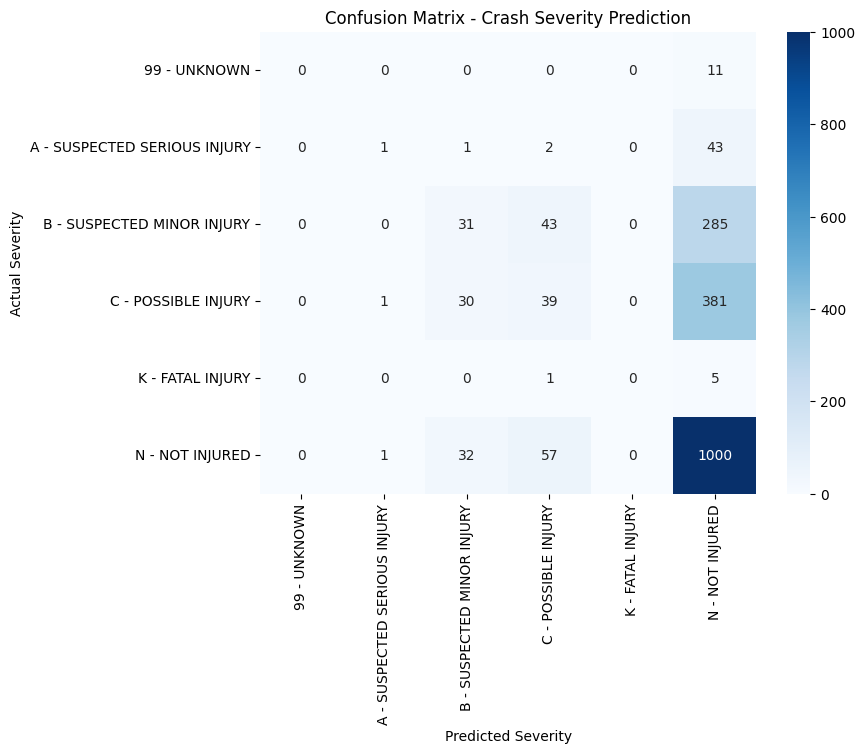

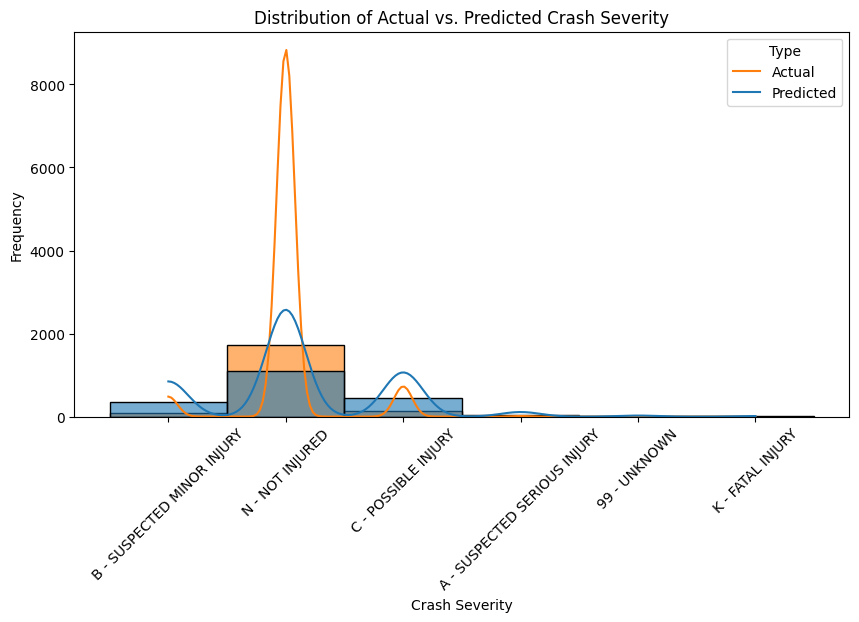

In [ ]:
from sklearn.utils import shuffle

print(" Model Performance Report:")
y_pred = best_model.predict(X_test)
# Decode y_test and y_pred back to original string labels
y_test_decoded = le_severity.inverse_transform(y_test)
y_pred_decoded = le_severity.inverse_transform(y_pred)

# Print Classification Report using decoded labels
print(classification_report(y_test_decoded, y_pred_decoded, zero_division=1))

# Print Accuracy
print(" Model Accuracy:", best_accuracy)

# Convert Encoded Labels Back to Original Severity Values
y_test_labels = le_severity.inverse_transform(y_test)
y_pred_labels = le_severity.inverse_transform(y_pred)

# Create a DataFrame for Actual vs. Predicted Comparison
results_df = pd.DataFrame({"Actual Severity": y_test_labels, "Predicted Severity": y_pred_labels})

# Identify correctly and incorrectly predicted cases
correct_preds = results_df[results_df["Actual Severity"] == results_df["Predicted Severity"]]
incorrect_preds = results_df[results_df["Actual Severity"] != results_df["Predicted Severity"]]

# Sample an equal number of correct and incorrect predictions
sample_size = min(len(correct_preds), len(incorrect_preds))
sampled_correct = correct_preds.sample(n=sample_size, random_state=42)
sampled_incorrect = incorrect_preds.sample(n=sample_size, random_state=42)

# Combine and shuffle to ensure randomness
balanced_results = pd.concat([sampled_correct, sampled_incorrect])
balanced_results = shuffle(balanced_results, random_state=42)

# Display first 20 results for a more balanced representation
print("\n Representative 20 Predictions vs. Actual Values:")
print(balanced_results.head(20))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_severity.classes_, yticklabels=le_severity.classes_)
plt.xlabel("Predicted Severity")
plt.ylabel("Actual Severity")
plt.title("Confusion Matrix - Crash Severity Prediction")
plt.show()

#  Fix: Use Decoded Labels for Predicted vs. Actual Distribution
results_df["Actual Severity"] = results_df["Actual Severity"].astype("category")
results_df["Predicted Severity"] = results_df["Predicted Severity"].astype("category")

# Reshape DataFrame for sns.histplot()
results_melted = results_df.melt(var_name="Type", value_name="Severity")

# Plot Predicted vs. Actual Response Distribution (With Decoded Labels)
plt.figure(figsize=(10, 5))
sns.histplot(data=results_melted, x="Severity", hue="Type", kde=True, alpha=0.6)
plt.title("Distribution of Actual vs. Predicted Crash Severity")
plt.xlabel("Crash Severity")
plt.ylabel("Frequency")
plt.legend(title="Type", labels=["Actual", "Predicted"])
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()
